# Import libraries

In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

from sklearn.datasets import load_digits
from sklearn import manifold

from scipy.spatial.distance import pdist, squareform

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

import folium

from scipy.stats import zscore

%matplotlib notebook
import matplotlib.gridspec as gridspec

METRIC = True
CAPITALS = ['Yerevan','Istanbul','Cairo','Konya','Isfahan']

def remove_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax


from sklearn.metrics import euclidean_distances

def plot_mds(similarities,ax,input_is_corr=False,xlim=None,ylim=None):
    # similarities is a dissimilarity matrix
        
    # plt.matshow(similarities)
    seed = np.random.RandomState(seed=3)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-21, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    if METRIC is False:
        nmds = manifold.MDS(n_components=2, metric=False, max_iter=300000, eps=1e-19,
                            dissimilarity="precomputed", random_state=seed, n_jobs=4,
                            n_init=1)
        pos = nmds.fit_transform(similarities, init=pos)    
    ax.plot(pos[:,0],pos[:,1],'ok',markersize=10)
    for i, txt in enumerate(symm_df.columns):
        ax.annotate(txt, (pos[i,0]+0.015,  pos[i,1]),fontsize=12)
    ax.set_ylabel('Dim2',fontsize=16)
    ax.set_xlabel('Dim1',fontsize=16)
    ax = remove_top_right(ax)
    ax.grid()
    plt.tight_layout()
    ax.set_aspect('equal')
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    if xlim is not None:
        S=xlim/2.0
        Tx = np.arange(-xlim, xlim+S,step=S)
        Ty = np.arange(-ylim, ylim+S,step=S)
        ax.set_xticks(Tx)
        ax.set_yticks(Ty)
        ax.set_ylim(-ylim,ylim)
        ax.set_xlim(-xlim,xlim)
    return ax

def correlation_panel(corr,ax,input_is_corr=False,TITLE='Correlation Matrix',annotate=True,cbar=True,MASK=None):
    # corr is a distance matrix
    # plot the heatmap
    TICKLABELS = corr.columns.str.replace(' ','\n')
    if annotate is True:
        sns.heatmap(corr, 
                xticklabels=TICKLABELS,
                yticklabels=TICKLABELS,
                cmap="RdBu_r",
                square=True,
                ax=ax,
                cbar_kws={"shrink": 0.5},
                annot=corr.values,
                cbar=cbar,mask=MASK)
    else:
        sns.heatmap(corr, 
        xticklabels=TICKLABELS,
        yticklabels=TICKLABELS,
        cmap="RdBu_r",
        square=True,
        ax=ax,
        cbar_kws={"shrink": 0.5},
        cbar=cbar,
        mask=MASK)
    ax.set_title(TITLE,fontsize=16)
    ax.set_yticklabels(TICKLABELS,fontsize=12,va='center')
    ax.set_xticklabels(TICKLABELS,fontsize=12,ha='center')
    plt.tight_layout()
    return ax
    #biraz deli bir renk oldu ama simdilik kalsin.
    
@memory.cache
def get_geo_distances(capitals):
    geolocator = Nominatim(user_agent="bla")
    Distance = np.zeros((len(capitals),len(capitals)))
    for i,c1 in enumerate(capitals):
        for j,c2 in enumerate(capitals):
            l1 = geolocator.geocode(c1)
            l2 = geolocator.geocode(c2)
            d = geodesic(l1.point, l2.point).km
            Distance[i,j] = d
    return Distance


# Import Data

In [4]:
symm_df = pd.read_excel("./symm_groups.xlsx",index_col=0)
symm_df = symm_df.iloc[:17,[3,2,1,4,5]]
symm_df = symm_df.astype(float)

In [5]:
symm_df

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks
p1,0.8,14.04,0.000,0.27,0.8
p1m1,4.9,9.65,0.000,0.00,0.0
p1g1,0.0,0.88,0.000,0.00,0.8
c1m1,2.4,4.39,0.000,0.55,0.0
p211,0.0,2.63,3.600,1.10,2.4
p2mm,5.7,9.65,5.778,8.79,6.4
p2mg,0.8,5.26,0.442,0.82,0.8
p2gg,0.8,0.88,0.000,0.55,3.2
c2mm,1.6,3.51,12.890,8.52,11.2
p3,0.8,0.00,0.000,0.82,0.0


In [23]:
dist_symm = pd.DataFrame(squareform(pdist(symm_df.T.values,'correlation'))
                            ,index=symm_df.columns, columns= symm_df.columns)
TOTAL_CULTURE = dist_symm.shape[0]
dist_symm

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks
Armenian,0.000000,0.151601,0.360031,0.280780,0.244786
Eastern Roman,0.151601,0.000000,0.573263,0.520043,0.435763
Middle East Arabs,0.360031,0.573263,0.000000,0.026509,0.094417
Rum Seljuks,0.280780,0.520043,0.026509,0.000000,0.063056
Great Seljuks,0.244786,0.435763,0.094417,0.063056,0.000000


In [22]:
dist_symm_euc = pd.DataFrame(squareform(pdist(symm_df.T.values))
                            ,index=symm_df.columns, columns= symm_df.columns)
dist_symm_euc

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks
Armenian,0.000000,28.763503,40.483553,35.974045,35.071926
Eastern Roman,28.763503,0.000000,40.919454,35.912037,30.709300
Middle East Arabs,40.483553,40.919454,0.000000,10.314757,18.661792
Rum Seljuks,35.974045,35.912037,10.314757,0.000000,12.755544
Great Seljuks,35.071926,30.709300,18.661792,12.755544,0.000000


# Histogram of Symmetry Groups

<IPython.core.display.Javascript object>


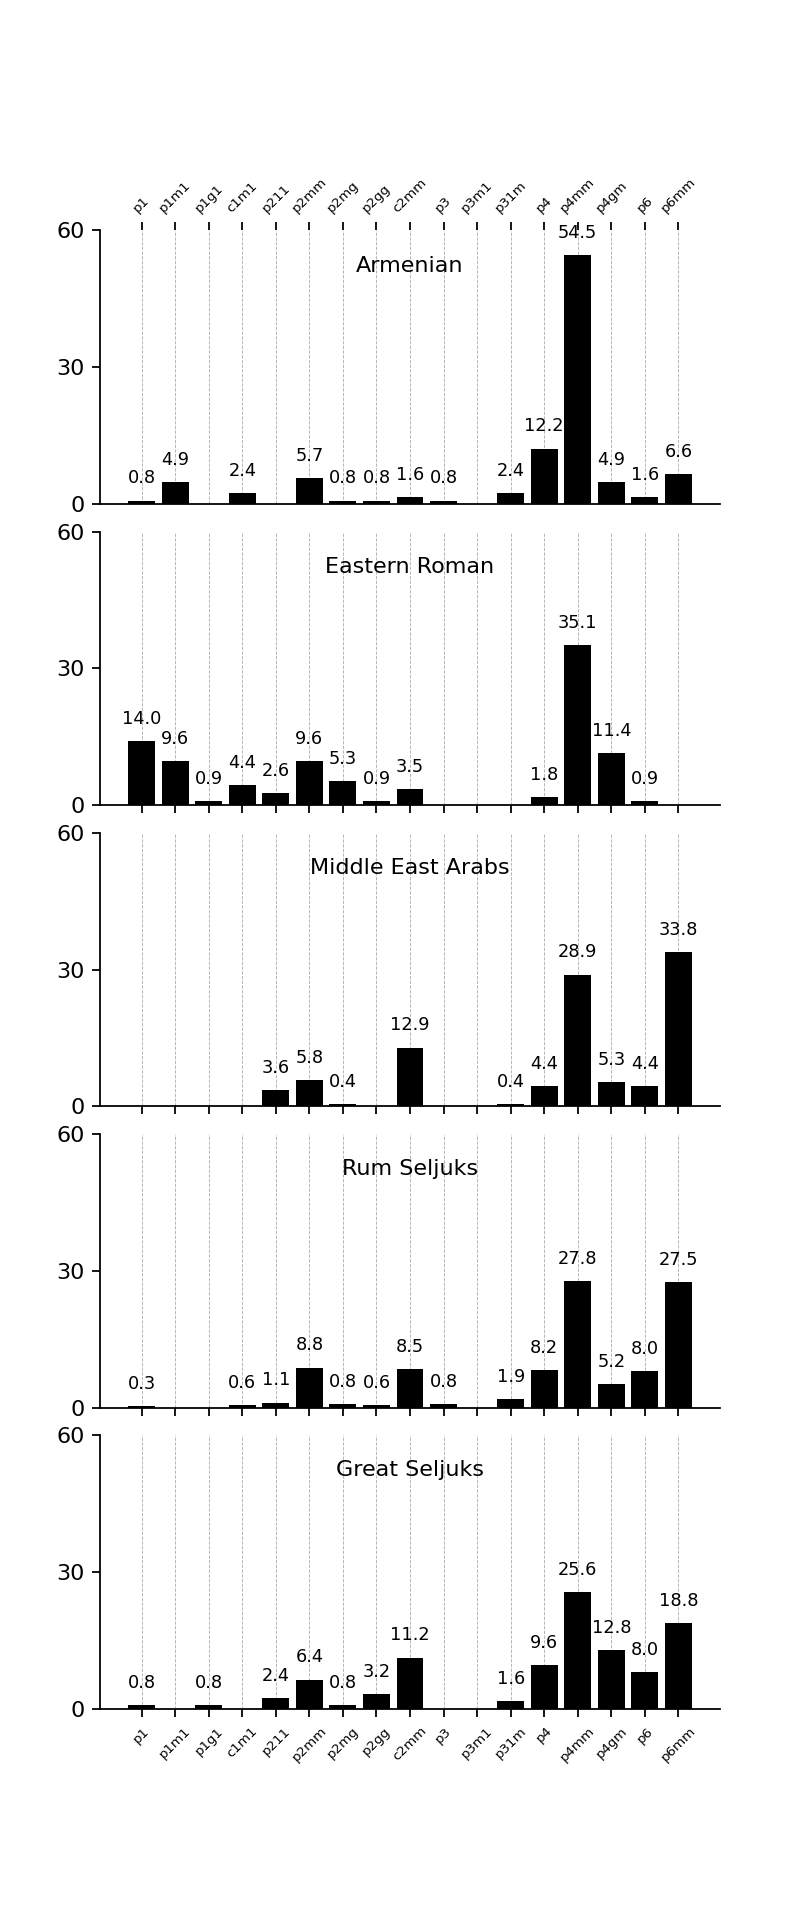

In [6]:
## FIGURE
fig = plt.figure(figsize=(TOTAL_CULTURE,12))
gs1 = gridspec.GridSpec(TOTAL_CULTURE,1)
gs1.update( hspace=0.1) # set the spacing between axes. 


cols = symm_df.columns.to_list() 
for i in np.arange(TOTAL_CULTURE):
    ax = plt.subplot(gs1[i])
    ax.bar(range(0,17),symm_df[cols[i]],color='k')
    ax = remove_top_right(ax)
    ax.set_xticks(np.arange(symm_df.shape[0]))
    if i == TOTAL_CULTURE-1:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
    elif i == 0:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
    else:
        ax.set_xticklabels('')
    for p in ax.patches:
        if np.ceil(p.get_height()) != 0:
            ax.annotate(np.round(p.get_height(),decimals=1),
                        (p.get_x()+p.get_width()/2., 
                         p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax.set_title(cols[i], y=0.8, loc = 'center',fontsize=10)
    ax.set_ylim([0,60])
    ax.set_yticks([0,30,60])
    ax.grid(axis='x', linestyle='--', linewidth=.4)
    ax.set_axisbelow(True)

    
plt.subplots_adjust(hspace=.5)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_histograms.png',dpi=1000)

# Correlation between Symmetry Groups

<IPython.core.display.Javascript object>


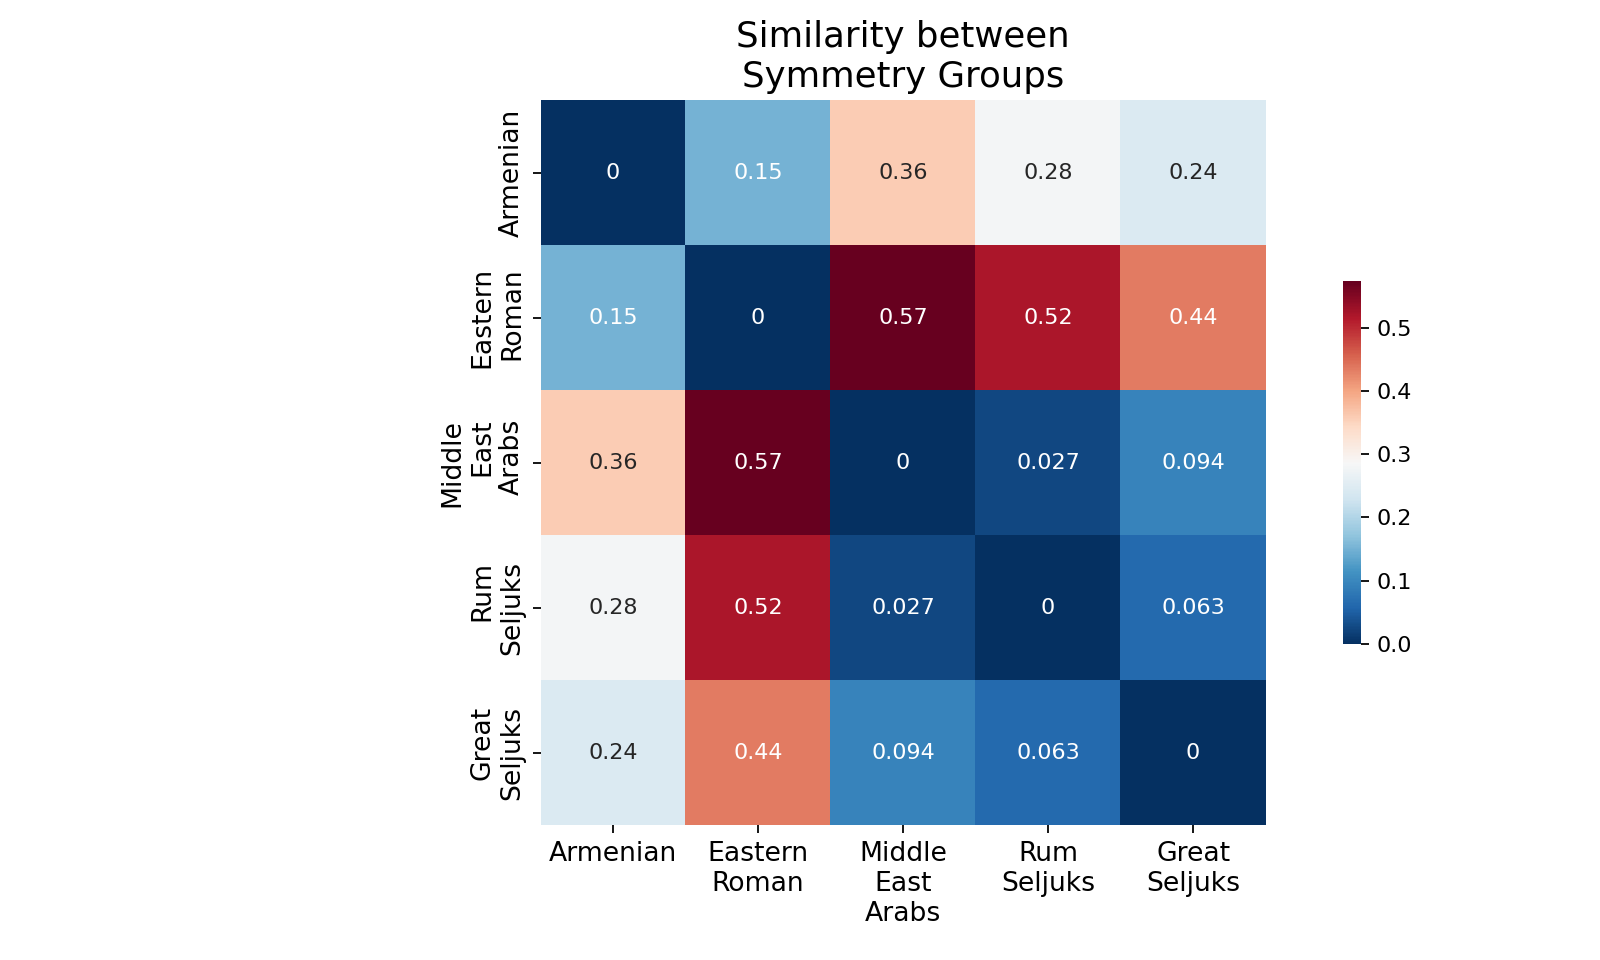

<AxesSubplot:title={'center':'Similarity between\nSymmetry Groups'}>

In [24]:
fig = plt.figure(figsize=(10,6))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm,ax=ax,TITLE='Similarity between\nSymmetry Groups')

# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_corrmat.png',
#                 dpi=1000,
#                 )

# Euclidean Distance between Groups

<IPython.core.display.Javascript object>


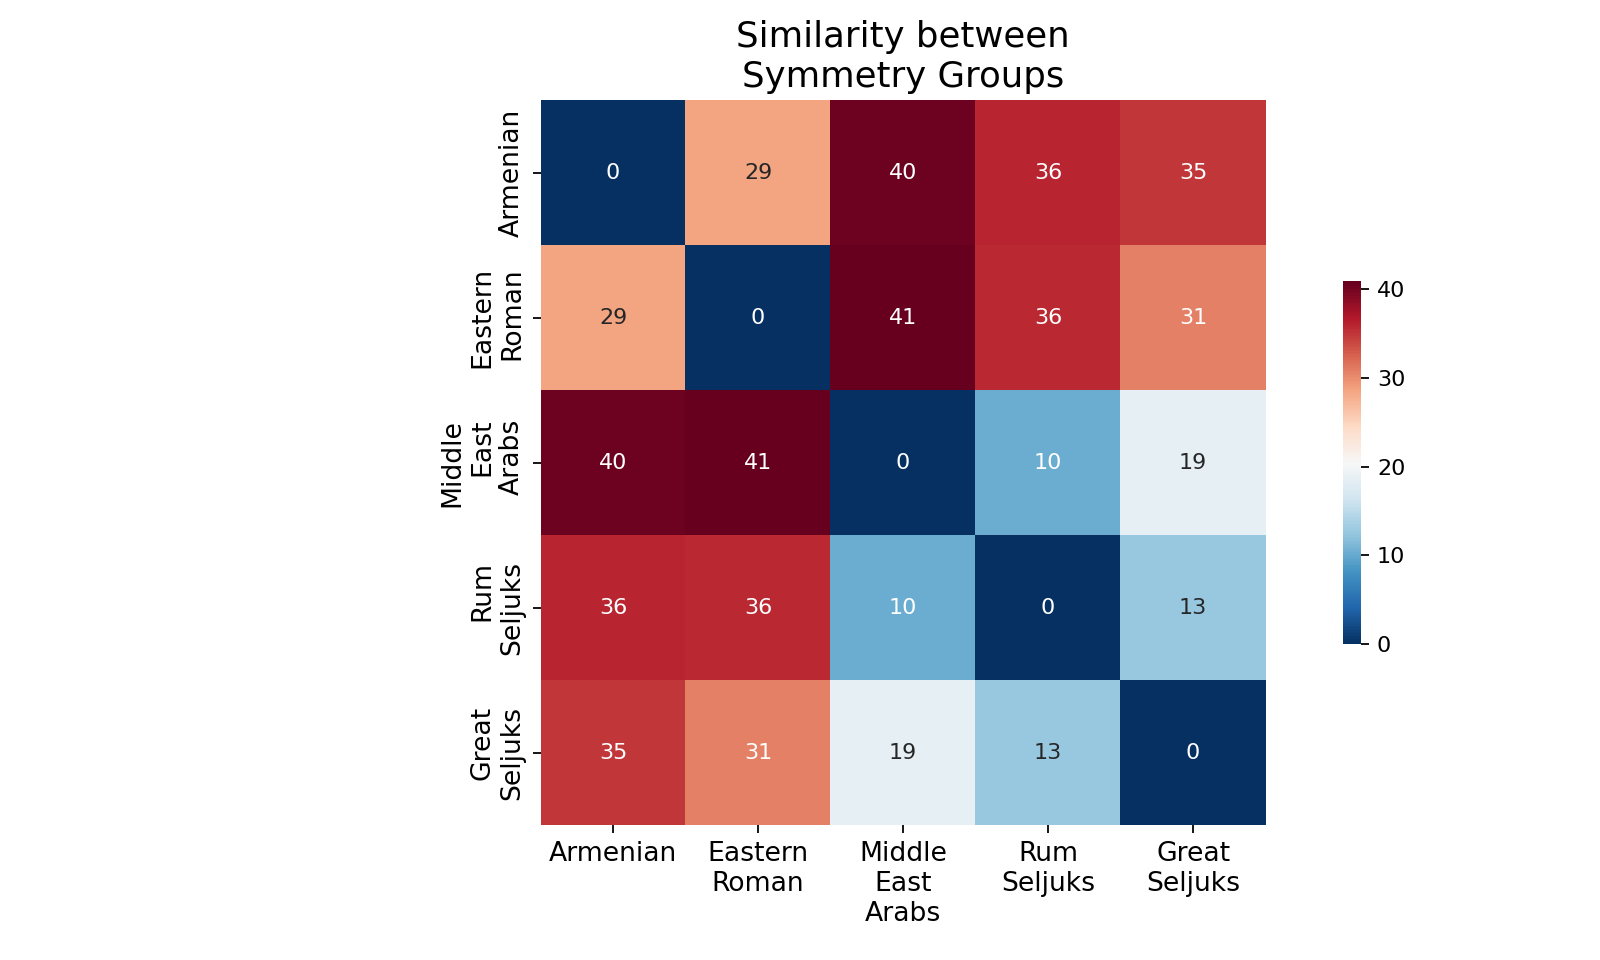

<AxesSubplot:title={'center':'Similarity between\nSymmetry Groups'}>

In [25]:
fig = plt.figure(figsize=(10,6))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm_euc,ax=ax,TITLE='Similarity between\nSymmetry Groups')

# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_corrmat.png',
#                 dpi=1000,
#                 )

# Geographic Proximity Matrix

## Compute a geographical distance matrix akin to the correlation matrix.

<IPython.core.display.Javascript object>


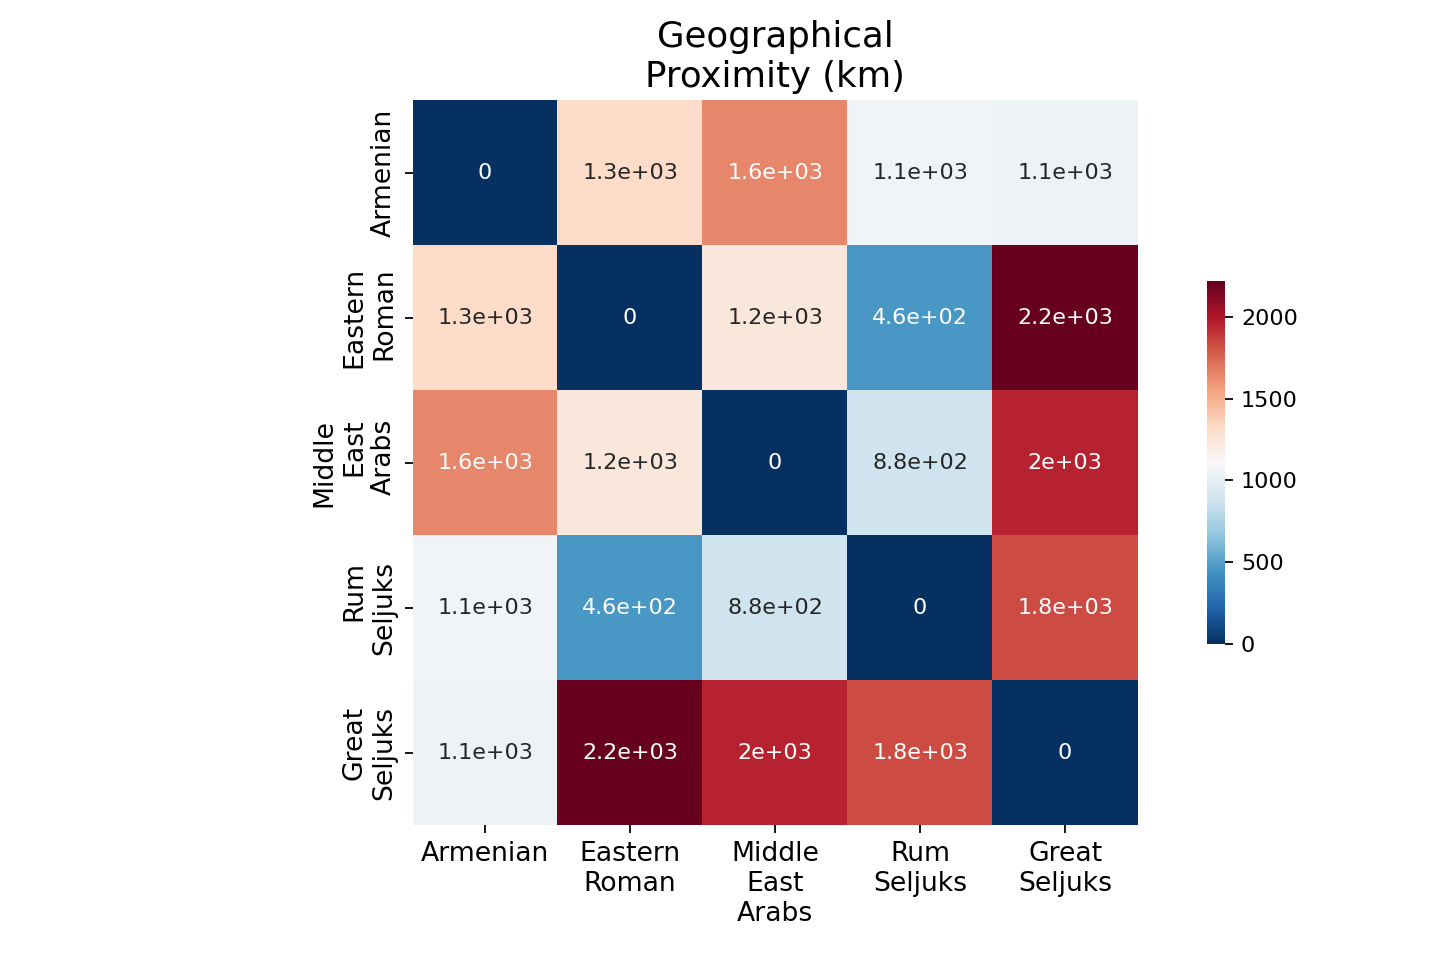

<AxesSubplot:title={'center':'Geographical\nProximity (km)'}>

In [8]:
dist_geo_full = get_geo_distances(CAPITALS)
dist_geo_full = pd.DataFrame(dist_geo_full,columns=symm_df.columns.values,index=symm_df.columns.values)
dist_geo = np.triu(dist_geo_full.values,1)
dist_geo = pd.DataFrame(dist_geo,columns=CAPITALS,index=CAPITALS)


fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
correlation_panel(dist_geo_full,ax,input_is_corr=True,TITLE='Geographical\nProximity (km)',annotate=True)

# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_geographical_proximity.png',dpi=1000,)

# MDS on geographical distances

## This MDS should recover coordinates of the cultural captials.

<IPython.core.display.Javascript object>


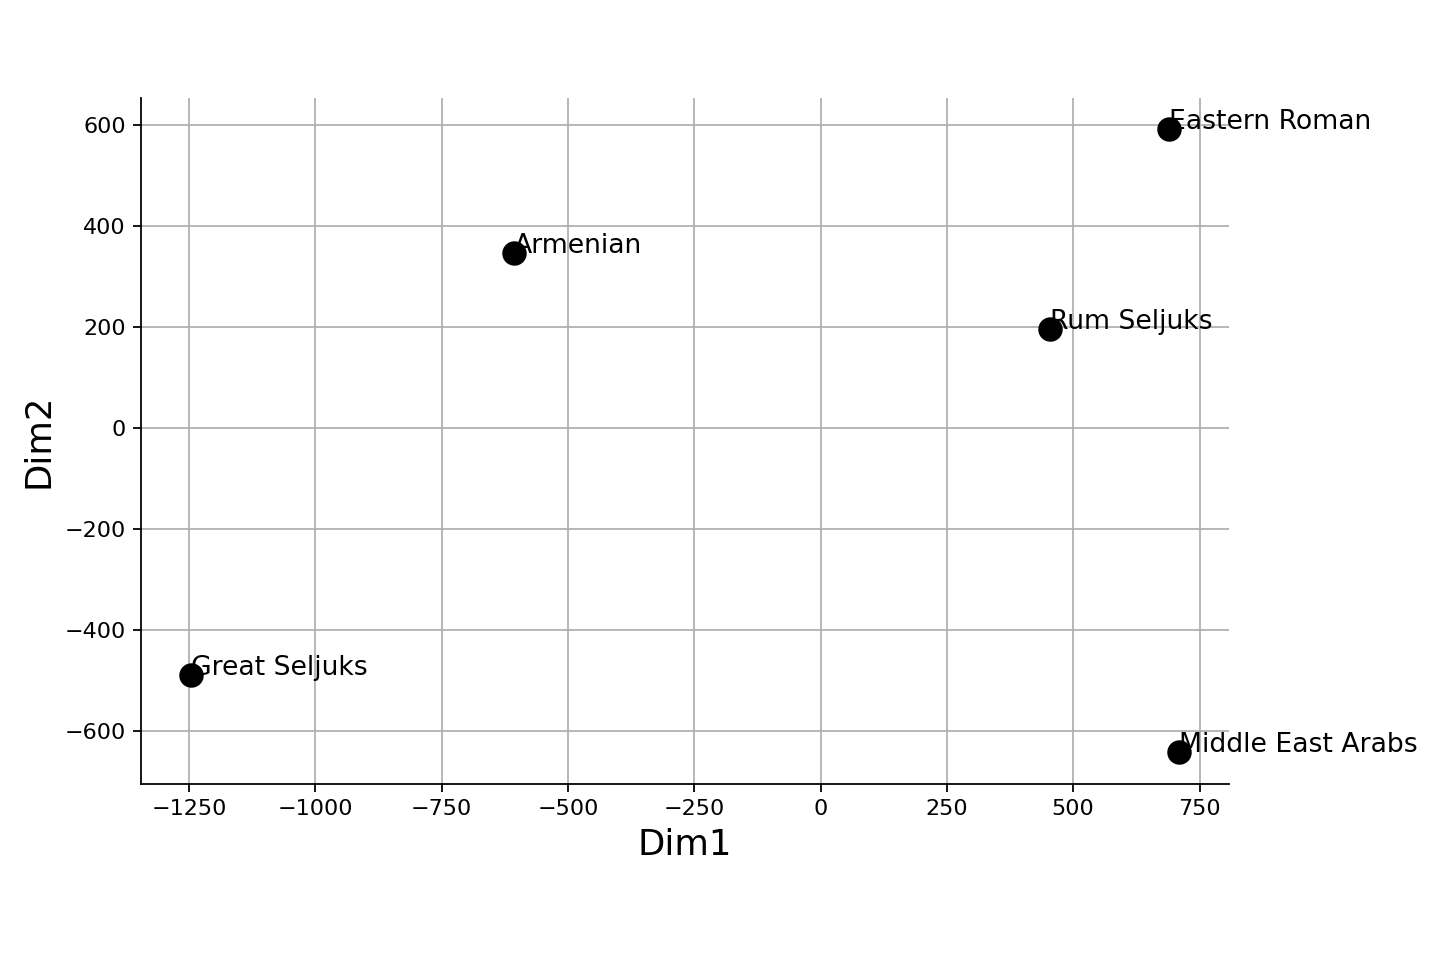

<AxesSubplot:xlabel='Dim1', ylabel='Dim2'>

In [9]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
plot_mds(dist_geo_full,ax,input_is_corr=True)

# MDS on Symmetry Similarity

<IPython.core.display.Javascript object>


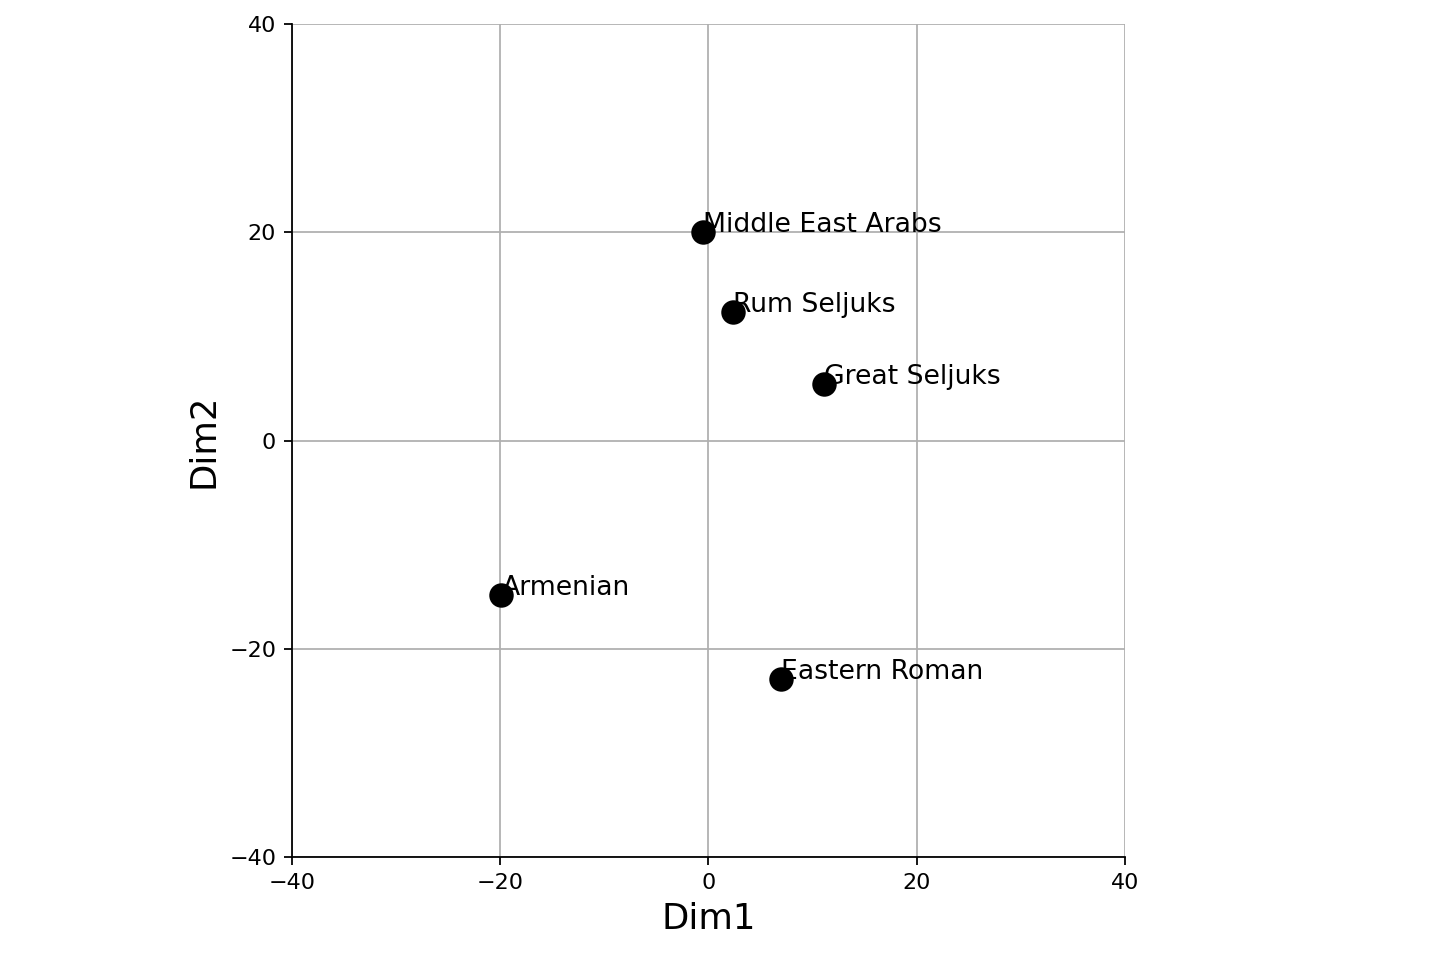

In [33]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
ax  = plot_mds(dist_symm_euc ,ax,xlim=40,ylim=40)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_mds.png',dpi=1000)

# Religious Proximity Matrix

<IPython.core.display.Javascript object>


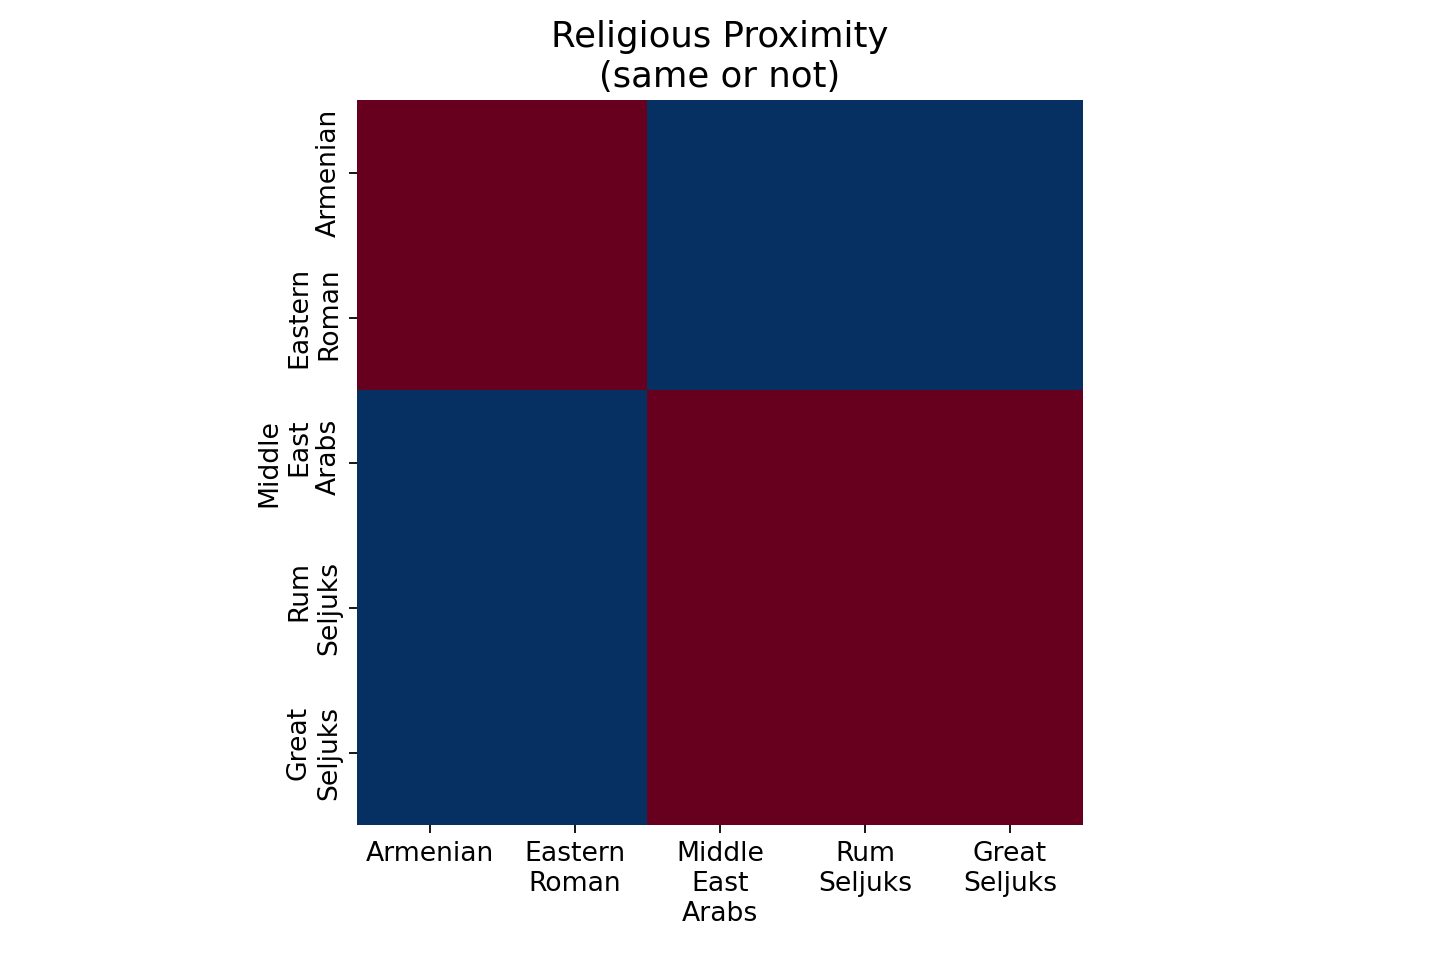

In [11]:
# Religious similarity matrix
Religion      = [1,1,-1,-1,-1]
dist_religion = np.outer(Religion,Religion)
# dist_religion = np.triu(dist_religion,1)

dist_religion = pd.DataFrame(dist_religion,columns=symm_df.columns,index=symm_df.columns)
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
ax = correlation_panel(dist_religion,ax,input_is_corr=True,TITLE='Religious Proximity\n(same or not)',annotate=False,cbar=False)
# plt.savefig('/Users/sonat/Documents/repos/ornament_symmgroups/figure_religousproximity.png',dpi=1000)

# Linear Regression

## We are asking the question of how to explain the similarity matrix of symmetries shown in 3.1. As potential explanatory variables, we use geographic proximity matrix as well as religious proximity matrix.

<IPython.core.display.Javascript object>


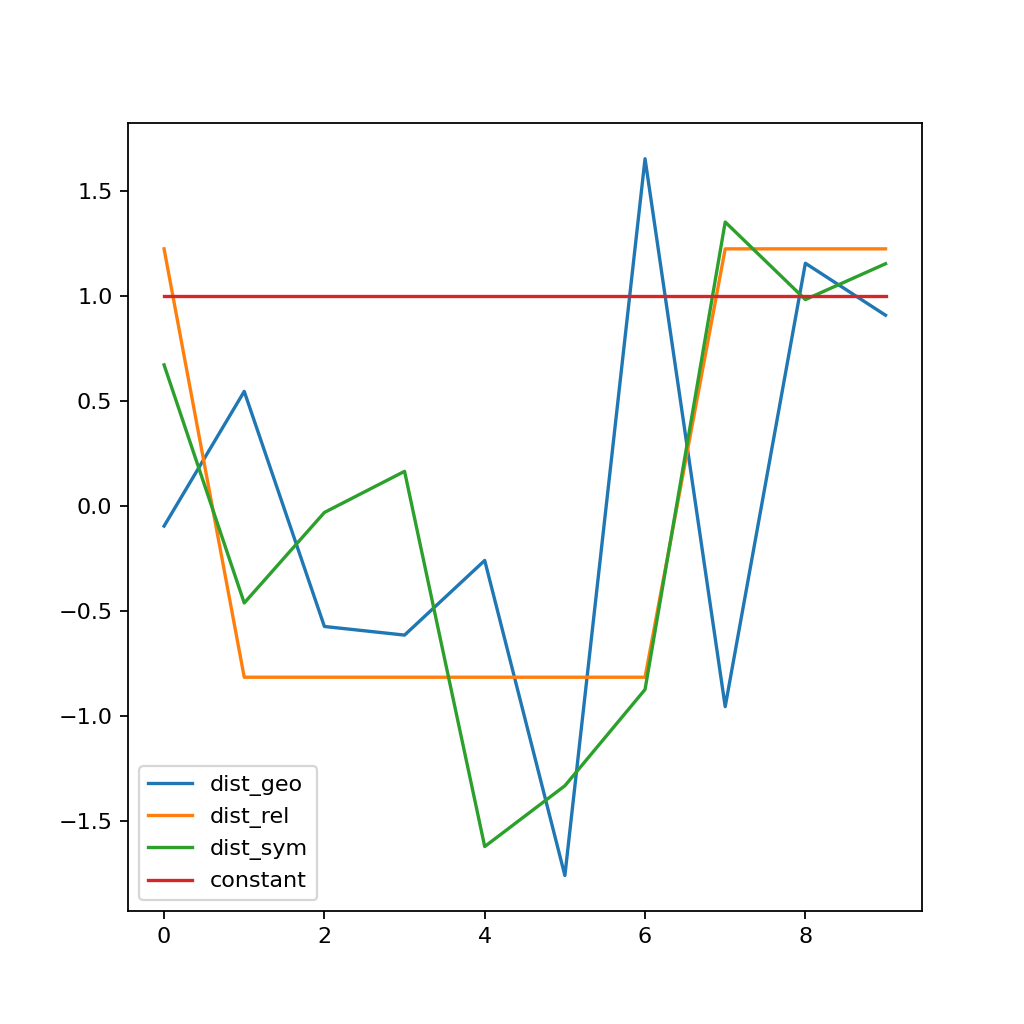

<AxesSubplot:>

In [12]:
sim             = pd.DataFrame()

i               = np.triu_indices(TOTAL_CULTURE,k=1)
sim["dist_geo"] = dist_geo.values[i]
sim["dist_rel"] = dist_religion.values[i]
sim["dist_sym"] = dist_symm.values[i]

sim =  sim.apply(zscore)
sim["constant"] = 1
fig,ax = plt.subplots(1,1,figsize=(4,4))
sim.plot(ax=ax)

In [13]:
import statsmodels.api as sm

X = sim[['dist_geo','dist_rel','constant']]
y = sim["dist_sym"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/Users/onat/Documents/ornament_symmgroups/.env/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dist_sym   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     9.070
Date:                Fri, 21 Aug 2020   Prob (F-statistic):             0.0114
Time:                        12:25:53   Log-Likelihood:                -7.7967
No. Observations:                  10   AIC:                             21.59
Df Residuals:                       7   BIC:                             22.50
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dist_geo       0.0062      0.204      0.031      0.976      -0.476       0.488
dist_rel       0.8481      0.204      4.161      0.004       0.366       1.330
constant   -8.327e-17      0.199  -4.17e-16      1.000      -0.472       0.472
==============================================================================
Omnibus:                        0.083   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.302
Skew:                          -0.090   Prob(JB):                        0.860
Kurtosis:                       2.167   Cond. No.                         1.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The linear modelling does return significant contribution of religious proximity but not geographical proximity.

I continue with the computation of correlations

In [14]:
sim.iloc[:,:3].corr()

,dist_geo,dist_rel,dist_sym
dist_geo,1.000000,0.206546,0.181408
dist_rel,0.206546,1.000000,0.849421
dist_sym,0.181408,0.849421,1.000000


<IPython.core.display.Javascript object>


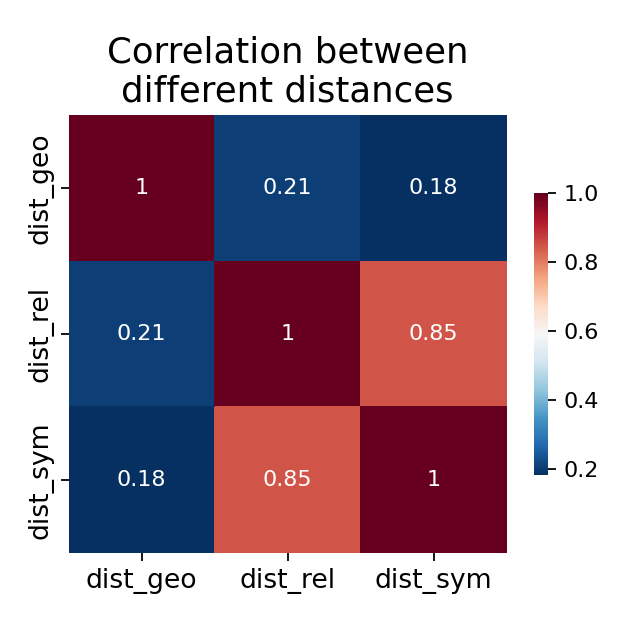

<AxesSubplot:title={'center':'Correlation between\ndifferent distances'}>

In [15]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
correlation_panel(sim.iloc[:,:3].corr(),
                  ax,
                  input_is_corr=True,
                  TITLE='Correlation between\ndifferent distances')

# Haritalar

In [16]:
df = pd.read_excel("./GeoList.xlsx",index_col=None,header=1)
df = df.reset_index(drop=True)
df = df.iloc[:,:5]
df.head(3)

,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey"
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey"
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey"


In [17]:
@memory.cache
def name_to_coor(name):
    if name is np.nan:
        lat,lon = (None,None)
        return lat,lon
    geolocator = Nominatim(user_agent="bla",timeout=10)
    location = geolocator.geocode(name)
    if not location is None:
        lat,lon = location.latitude,location.longitude
    else:
        lat,lon = None,None
    return lat,lon

for colname in ["Seljuks","Eastern Roman","ME Arabs", "Armenian","Andalusia Arabs"]:
    print(colname)
    df[colname + "_coor_lat"],df[colname + "_coor_long"] = zip(*df[colname].apply(name_to_coor))

df.head(4)

Seljuks
Eastern Roman
ME Arabs
Armenian
Andalusia Arabs


,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks,Seljuks_coor_lat,Seljuks_coor_long,Eastern Roman_coor_lat,Eastern Roman_coor_long,ME Arabs_coor_lat,ME Arabs_coor_long,Armenian_coor_lat,Armenian_coor_long,Andalusia Arabs_coor_lat,Andalusia Arabs_coor_long
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey",38.2546,28.0654,45.4372,12.3346,33.3024,44.3788,40.1776,44.5126,37.8846,-4.77601
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey",37.8137,29.1425,None,None,30.0488,31.2437,None,None,37.1831,-3.60219
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey",37.8741,30.849,None,None,33.5131,36.3096,None,None,37.3886,-5.99534
3,Valencia,Aleppo,NaN,NaN,"Incir han, Turkey",37.4788,30.5333,None,None,36.1992,37.1637,None,None,39.4697,-0.376335


In [18]:
#create a map
center_lat = df["Seljuks_coor_lat"].median()
center_lon = df["Seljuks_coor_long"].median()
this_map = folium.Map(prefer_canvas=True,location=[center_lat,center_lon],zoom_start = 3)
folium.TileLayer('stamenwatercolor').add_to(this_map)

def plotDot(lat,lon,color):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    
    for lat_,lon_ in zip(lat,lon):
        if not lat_ is None:
            folium.CircleMarker(location=[lat_,lon_],
                            radius=7,
                            weight=2,
                            color=color,
                            fill=True).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
plotDot(df["Seljuks_coor_lat"],df["Seljuks_coor_long"],color='red')
plotDot(df["Eastern Roman_coor_lat"],df["Eastern Roman_coor_long"],color='black')
plotDot(df["Armenian_coor_lat"],df["Armenian_coor_long"],color='green')
plotDot(df["ME Arabs_coor_lat"],df["ME Arabs_coor_long"],color='blue')
plotDot(df["Andalusia Arabs_coor_lat"],df["Andalusia Arabs_coor_long"],color='yellow')


this_map

# Time Diagram

In [19]:
next = 50
thick = 30
df = pd.DataFrame.from_dict({"Armenia" : [0,800,0+thick,1200],
                             "Seljuks":[0+next,1200,0+next+thick,1500],
                             "Eastern Roman" : [0+next*2,800,0+next*2+thick,1500],
                             "Moslem Arabs": [0+next*3,900,0+next*3+thick,1200]})
df

,Armenia,Seljuks,Eastern Roman,Moslem Arabs
0,0,50,100,150
1,800,1200,800,900
2,30,80,130,180
3,1200,1500,1500,1200


<IPython.core.display.Javascript object>


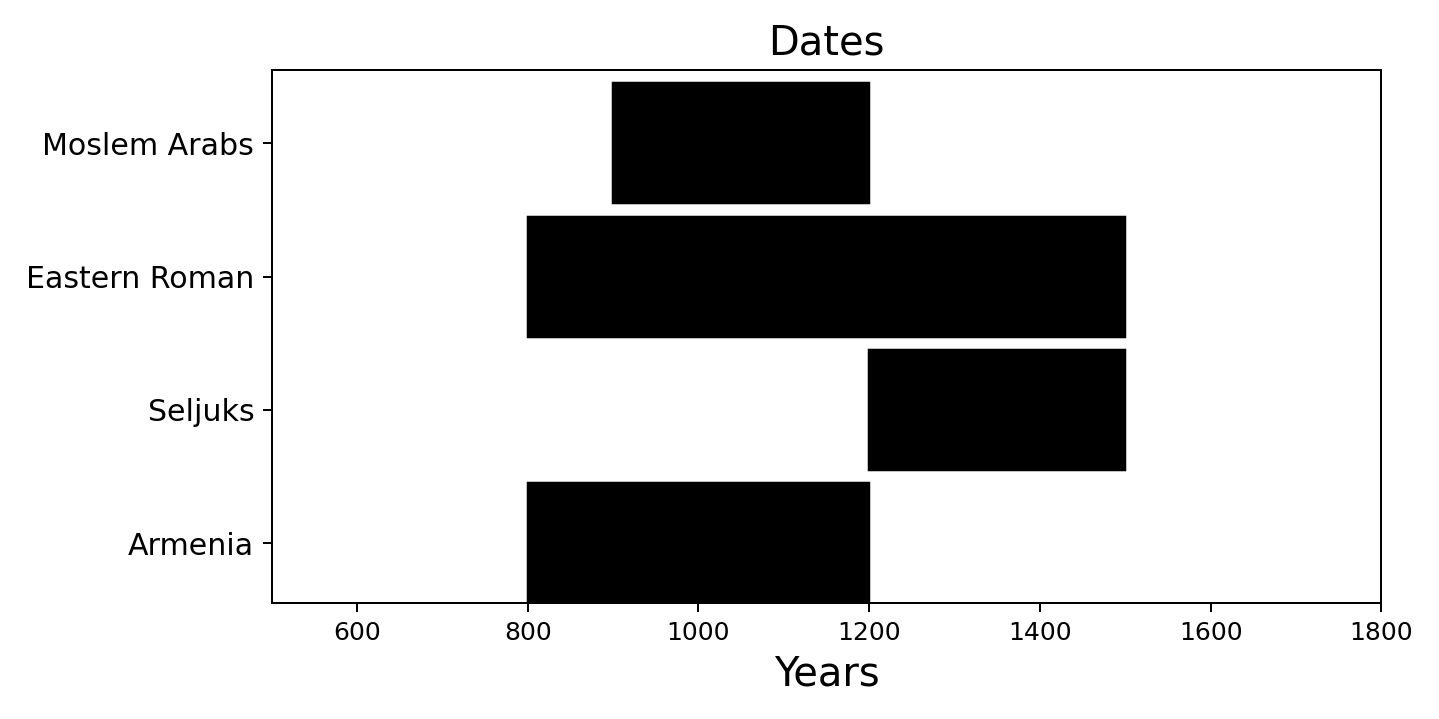

[   0  800   30 1200]
[  50 1200   80 1500]
[ 100  800  130 1500]
[ 150  900  180 1200]


In [20]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1,figsize=(8,4))
# Create a Rectangle patch
for cols in df.columns:
    val = df[cols].values
    print(val)
    rect = patches.Rectangle((val[1],val[0]),val[3]-val[1],45,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)


plt.show()
# plt.tight_layout()
ax.set_xlim(500,1800)
ax.set_ylim(0,200)
ax.set_yticks(np.array([0,50,100,150])+22.5)
ax.set_yticklabels(df.columns,fontsize=12)
ax.set_xlabel('Years',fontsize=16)
ax.set_title('Dates',fontsize=16)
plt.tight_layout()
